In [91]:
# import thư viện cần thiết
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
from easyocr import Reader

import warnings
warnings.filterwarnings('ignore')

In [92]:
# hàm lấy 4 điểm của biển số xe
def points(location):
    """
    Take locations of 4 points and return them in specific order
    bottom_right, top_right, bottom_left, top_left
    :param location: 4 random points
    :return: list of points in order: bottom_right, top_right, bottom_left, top_left
    """
    comparelist = []
    sortedlist = []
    for point in location:
        comparelist.append(np.sum(point))

    for i in range(4):
        max_pos = comparelist.index(max(comparelist[:]))
        sortedlist.append(location[max_pos])
        comparelist[max_pos] = 0

    return sortedlist

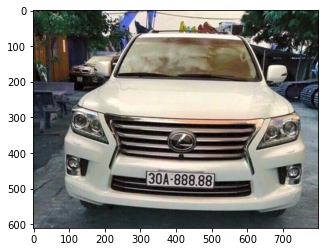

In [93]:
# đọc ảnh
img = cv2.imread('img1.jpg')
plt.imshow(img)
img_original = img.copy()

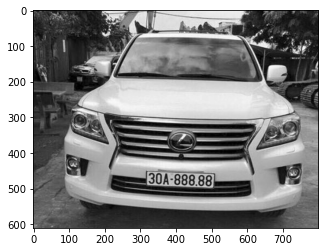

In [94]:
# chuyển thành ảnh xám
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.show()

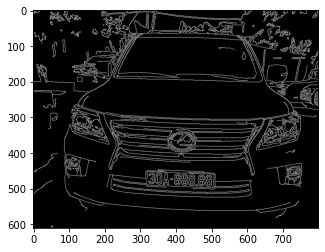

In [95]:
# giảm nhiễu và tìm biên bằng Canny
nfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(nfilter, 30, 200) #Edge detection

plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
plt.show()

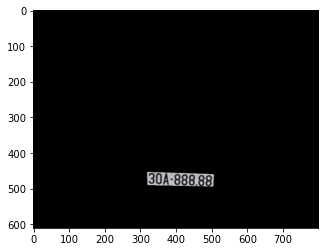

In [96]:
# Xác định countour
mainpoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(mainpoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

# Xác định vị trí biển số xe
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

# highlight biển số xe
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)


plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.show()

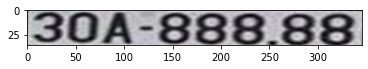

In [97]:
(bottom_right, top_right, bottom_left, top_left) = points(location)

# kiểm tra vị trí 4 điểm của biển số xe
if top_right[0][0] - top_left[0][0] < top_right[0][1] - top_left[0][1]:
    top_width = (((bottom_left[0][0] - top_left[0][0]) ** 2) + ((bottom_left[0][1] - top_left[0][1]) ** 2))
    bottom_width = np.sqrt(((bottom_right[0][0] - top_right[0][0]) ** 2) + ((bottom_right[0][1] - top_right[0][1]) ** 2))
    right_height = np.sqrt(((bottom_right[0][0] - bottom_left[0][0]) ** 2) + ((bottom_right[0][1] - bottom_left[0][1]) ** 2))
    left_height = np.sqrt(((top_left[0][0] - top_right[0][0]) ** 2) + ((top_left[0][1] - top_right[0][1]) ** 2))
    max_width = max(int(bottom_width), int(top_width)) // 100
    max_height = max(int(right_height), int(left_height))

    # Desired points values in the output image
    input_points = np.float32([top_left[0], top_right[0], bottom_left[0], bottom_right[0]])
    converted_points = np.float32([[0, 0], [0, max_height], [max_width, 0], [max_width, max_height]])
else:
    top_width = (((top_right[0][0] - top_left[0][0]) ** 2) + ((top_right[0][1] - top_left[0][1]) ** 2))
    bottom_width = np.sqrt(((bottom_right[0][0] - bottom_left[0][0]) ** 2) + ((bottom_right[0][1] - bottom_left[0][1]) ** 2))
    right_height = np.sqrt(((top_right[0][0] - bottom_right[0][0]) ** 2) + ((top_right[0][1] - bottom_right[0][1]) ** 2))
    left_height = np.sqrt(((top_left[0][0] - bottom_left[0][0]) ** 2) + ((top_left[0][1] - bottom_left[0][1]) ** 2))
    max_width = max(int(bottom_width), int(top_width)) // 100
    max_height = max(int(right_height), int(left_height))

    # Desired points values in the output image
    input_points = np.float32([top_left[0], top_right[0], bottom_left[0], bottom_right[0]])
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

# Perspective transformation biến đổi không gian tọa độ biển số xe
matrix = cv2.getPerspectiveTransform(input_points, converted_points)
img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))


plt.imshow(cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB))
plt.show()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


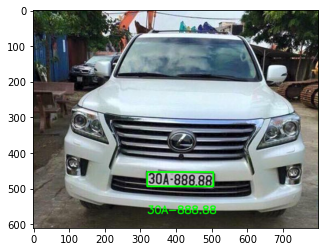

30A-888.88


In [98]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

reader = Reader(['en'])
result = reader.readtext(img_output)

text = result[0][-2]


# text = filtered_text(result[0][-2])
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+80), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()
# filtered_text(text)
print(text)